<a href="https://colab.research.google.com/github/eisbetterthanpi/pytorch/blob/main/gpt2_archive_uci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Gpt 2 is a generative model that predicts the next words, given an input sequence so some work needs to be done for gpt 2 to be used for classification.
We use the last token of the input sequence to predict the classification, instead of predicting the next word. 

fine tuning gpt 2 for classification
guide from [gmihaila](https://github.com/gmihaila) that can be found [here](https://gmihaila.github.io/tutorial_notebooks/gpt2_finetune_classification/)

scam/spam dataset from [archive.ics.uci.edu](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection)


In [ ]:
# download huggingface library for the transformer models
!pip install -q git+https://github.com/huggingface/transformers.git
# download the scam/spam dataset
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
# unzip the dataset into /content/spam folder
!unzip smsspamcollection.zip -d spam


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.5 MB 5.5 MB/s 
     |████████████████████████████████| 77 kB 5.7 MB/s 
     |████████████████████████████████| 895 kB 42.3 MB/s 
     |████████████████████████████████| 596 kB 45.1 MB/s 
--2022-04-09 11:03:33--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z 100%[===================>] 198.65K   969KB/s    in 0.2s    

2022-04-09 11:03:33 (969 KB/s) - ‘smsspamcollection.zip’ saved [203415/203415]

Archive:  smsspamcollection.zip
  inflating: spam/SMSSpamCollection  
  inflating:

import required libraries

import the pretrained gpt 2 model and helper functions from huggingface transformers

create dictionary according to the labels in the dataset
```
labels_ids = {'ham': 0, 'spam': 1}
```

In [ ]:
import io, os, torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score
from transformers import set_seed, GPT2Config, GPT2Tokenizer, AdamW, get_linear_schedule_with_warmup, GPT2ForSequenceClassification

set_seed(0)
# Pad or truncate text sequences to a specific length if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 60
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_or_path = 'gpt2'
labels_ids = {'ham': 0, 'spam': 1}
n_labels = len(labels_ids)



define custom pytorch dataset class.
the dataset contains the labels and text that are concatenated in a single string and the string may overflow to the next column. As such, the dataset needs to be formatted in the ```__init__ ``` method. first, the string for each row is concatenated into one, then split into the labels for the first column and text for the second column


The ```__getitem__ ``` method also needs to be redefined to return a dictionary in the format ```{'text':text, 'label':label}```

In [ ]:
import pandas as pd
import os
import numpy as np

class Datasetme(Dataset): #https://www.kaggle.com/code/pinocookie/pytorch-dataset-and-dataloader/notebook
    def __init__(self, path):
        self.data = pd.read_csv(path, on_bad_lines='skip', header=None)
        # self.data = pd.read_csv(path, on_bad_lines='skip', header=None, encoding='utf-8')
        self.data=self.data[self.data.notna()]
        self.data[0] = self.data.fillna('').sum(axis=1)
        self.data[[0,1]] = self.data[0].str.split('\t',expand=True)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        text = self.data.iloc[index, 1]
        label = self.data.iloc[index, 0]
        return {'text':text, 'label':label}

In [ ]:

class Gpt2ClassificationCollator(object):
    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):
        self.use_tokenizer = use_tokenizer
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Label encoder used inside the class.
        self.labels_encoder = labels_encoder
        return

    def __call__(self, sequences): #call function allows the class objesct to be used as a function call.
        texts = [sequence['text'] for sequence in sequences]
        labels = [sequence['label'] for sequence in sequences]
        # Encode all labels using label encoder.
        labels = [self.labels_encoder[label] for label in labels]
        # Call tokenizer on all texts to convert into tensors of numbers with appropriate padding.
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})
        return inputs

def train(dataloader, model, optimizer_, scheduler_):
    predictions_labels = []
    true_labels = []
    total_loss = 0
    model.train() # set model to train mode
    for batch in tqdm(dataloader, total=len(dataloader)):
        # Add original labels - use later for evaluation.
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()} # move batch to device
        model.zero_grad() # clear previously calculated gradients before backward pass.
        outputs = model(**batch)
        loss, logits = outputs[:2]
        total_loss += loss.item() #`.item()` returns the Python value from the tensor.
        loss.backward() # back propagate loss
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clip norm of gradients to 1.0 to help prevent the "exploding gradients"
        optimizer_.step()
        scheduler_.step() # Update the learning rate.
        logits = logits.detach().cpu().numpy()
        # Convert these logits to list of predicted labels values.
        predictions_labels += logits.argmax(axis=-1).flatten().tolist()
    # Calculate the average loss over the training data.
    avg_epoch_loss = total_loss / len(dataloader)
    # Return all true labels and prediction for future evaluations.
    return true_labels, predictions_labels, avg_epoch_loss

def test(dataloader, model):
    predictions_labels = []
    true_labels = []
    total_loss = 0
    model.eval() # set model to evaluation mode, stop computing gradients for better performance during inference
    for batch in tqdm(dataloader, total=len(dataloader)):
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            loss, logits = outputs[:2]
            logits = logits.detach().cpu().numpy()
            total_loss += loss.item()
            predict_content = logits.argmax(axis=-1).flatten().tolist()
            predictions_labels += predict_content
    avg_epoch_loss = total_loss / len(dataloader)
    # Return all true labels and prediciton for future evaluations.
    return true_labels, predictions_labels, avg_epoch_loss


In [ ]:

print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))
# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id
model.to(device)
print('Model loaded to `%s`'%device)


Loading configuraiton...


Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Loading tokenizer...


Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Loading model...


Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


In [ ]:

gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, labels_encoder=labels_ids, max_sequence_len=max_length)
batch_size = 32
file='/content/spam/SMSSpamCollection'

all_dataset = Datasetme(path=file)
test_size = 0.2
# split dataset into 20% test, 80% train
train_dataset, valid_dataset = torch.utils.data.random_split(all_dataset, [int((1-test_size)*len(all_dataset)), int(test_size*len(all_dataset))])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)



In [ ]:
epochs = 4 #2-4?

# AdamW class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),lr = 2e-5, eps = 1e-8)
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

for epoch in tqdm(range(epochs)):
    print('Training on batches...')
    train_labels, train_predict, train_loss = train(train_dataloader, model, optimizer, scheduler)
    train_acc = accuracy_score(train_labels, train_predict)
    valid_labels, valid_predict, val_loss = test(valid_dataloader, model)
    val_acc = accuracy_score(valid_labels, valid_predict)
    print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/4 [00:00<?, ?it/s]

Training on batches...


  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  train_loss: 0.25489 - val_loss: 0.10136 - train_acc: 0.89601 - valid_acc: 0.95965
Training on batches...


  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  train_loss: 0.11225 - val_loss: 0.07613 - train_acc: 0.96542 - valid_acc: 0.97695
Training on batches...


  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  train_loss: 0.07260 - val_loss: 0.07279 - train_acc: 0.97622 - valid_acc: 0.98271
Training on batches...


  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  train_loss: 0.05838 - val_loss: 0.07121 - train_acc: 0.98223 - valid_acc: 0.98079




print classification_report from sklearn.metrics

plot confusion matrix


  0%|          | 0/33 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       912
        spam       0.92      0.93      0.92       129

    accuracy                           0.98      1041
   macro avg       0.95      0.96      0.96      1041
weighted avg       0.98      0.98      0.98      1041



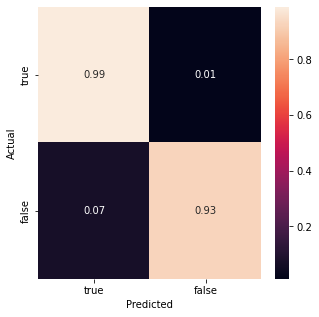

In [ ]:

true_labels, predictions_labels, avg_epoch_loss = test(valid_dataloader, model)
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
print(evaluation_report)

# for confusion matrix
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_true=true_labels, y_pred=predictions_labels)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['true','false'], yticklabels=['true','false'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [ ]:
# (optional:) mount to google drive to save the model
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# PATH="/content/gdrive/MyDrive/gpt2_archive_uci" # for saving to google drive
PATH="/content" # for saving on colab only

model.save_pretrained(PATH)
tokenizer.save_pretrained(PATH)


('/content/tokenizer_config.json',
 '/content/special_tokens_map.json',
 '/content/vocab.json',
 '/content/merges.txt',
 '/content/added_tokens.json')

load the model, model config and tokenizer to do inference without having to finetune the model again.

In [ ]:
# load model
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=PATH, num_labels=n_labels)
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=PATH)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=PATH, config=model_config)


test out the model.
uncomment one text with ctrl + /
or redefine the text variable.

In [ ]:
model.eval()
############# true ham #############
# text="yo! whatssup?"
# text="redbull gives you heart palpitations"
# text="FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF"
text="HEY! CHECK THIS OUT! https://youtu.be/tr_HhHhnW74"
# text="!!!WTS"
# text="bruh bruh bruh bruh bruh bruh bruh bruh bruh bruh bruh bruh"

############# true spam #############
# text="BUY NOW!!! limited time only!"
# text="Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

############# false spam? 😳 #############
# text="buy sell"
# text="betting?"

tokenized_text = tokenizer([text], padding=True, return_tensors='pt')
output = model(tokenized_text["input_ids"])
prediction = torch.argmax(output.logits)
# print(prediction)
print(['ham', 'spam'][prediction])

spam
